In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from sklearn.metrics import mean_squared_error


In [12]:
data = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv')
data = data.set_index('Datetime')
data.index = pd.to_datetime(data.index)

In [14]:
data.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


<AxesSubplot:xlabel='Datetime', ylabel='PJME_MW'>

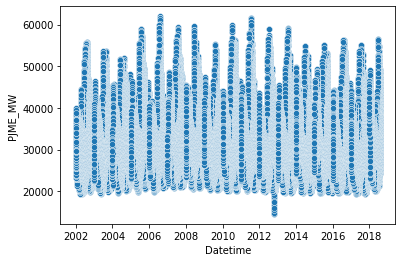

In [16]:
#checking distribution of the data 
sns.scatterplot(x='Datetime',y='PJME_MW',data= data)


In [17]:
train = data[data.index<'01-01-2015']
test = data[data.index>='01-01-2015']

Text(0.5, 1.0, 'Training Data VS Test Data')

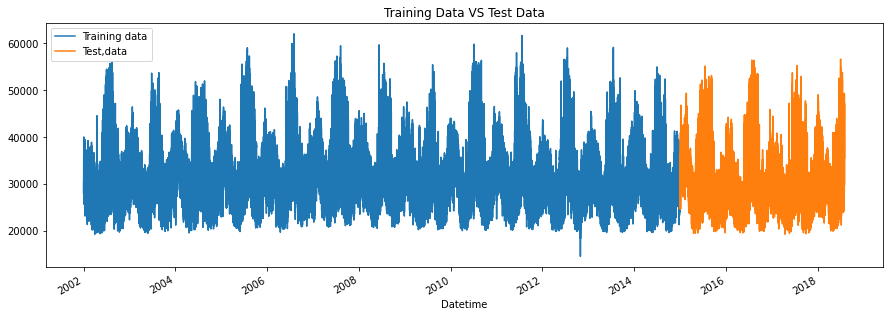

In [18]:
fig,ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax,label='Training Data')
test.plot(ax=ax,label='Test Data')
ax.legend(['Training data','Test,data'])
ax.set_title('Training Data VS Test Data')

<AxesSubplot:xlabel='Datetime'>

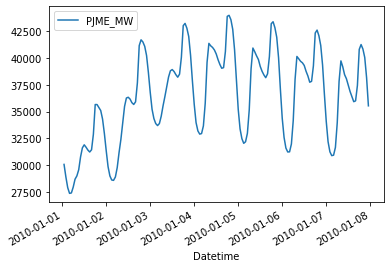

In [20]:
data.loc[(data.index>'01-01-2010') & (data.index<'01-08-2010')].plot()

In [21]:
#Feature Engg.
def feat_eng(data):
    data['hour']=data.index.hour
    data['dayofweek']=data.index.day_of_week
    data['quater']=data.index.quarter
    data['month']=data.index.month
    data['year']=data.index.year
    data['dayofyear']=data.index.dayofyear
    return data

In [22]:
data = feat_eng(data)

<AxesSubplot:xlabel='hour', ylabel='PJME_MW'>

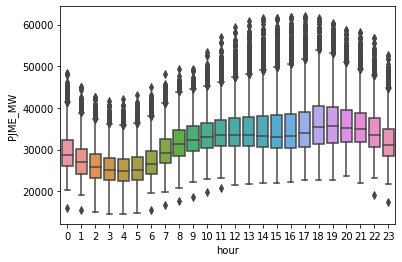

In [23]:
#relationship between features and target
sns.boxplot(data=data,x='hour',y='PJME_MW')

As we can see there is a dip in the energy consumption which got constant in the rest of the day.

<AxesSubplot:xlabel='month', ylabel='PJME_MW'>

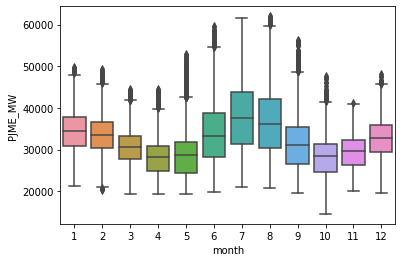

In [24]:
sns.boxplot(data=data,x='month',y='PJME_MW')

The energy consumption got during winters and mid-summer(autummn season) shows the peak than the rest.

In [25]:
train = feat_eng(train)
test =  feat_eng(test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [26]:
feat = ['hour', 'dayofweek', 'quater', 'month', 'year', 'dayofyear']
target = 'PJME_MW'

In [27]:
X_train = train[feat]
y_train = train[target]

X_test = test[feat]
y_test = test[target]

In [28]:
#Creating Model
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,laearning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[16:31:26] WARNING: ../src/learner.cc:627: 
Parameters: { "laearning_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:23192.08347	validation_1-rmse:22262.72116
[60]	validation_0-rmse:1938.07648	validation_1-rmse:4240.82202


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             laearning_rate=0.01, learning_rate=0.300000012, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [29]:
#feature importance
f = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['important_features'])

<AxesSubplot:title={'center':'Important Features'}>

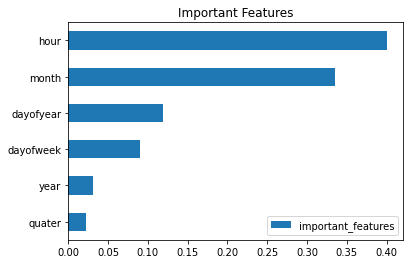

In [30]:
f.sort_values('important_features').plot(kind='barh',title='Important Features')

In [31]:
#forcast on test
test['predictions'] = reg.predict(X_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
data = data.merge(test[['predictions']], how='left', left_index=True, right_index=True)
data

,PJME_MW,hour,dayofweek,quater,month,year,dayofyear,predictions
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,40108.804688
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,40108.804688
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,38110.726562


Text(0.5, 1.0, 'Raw Data and Prediction')

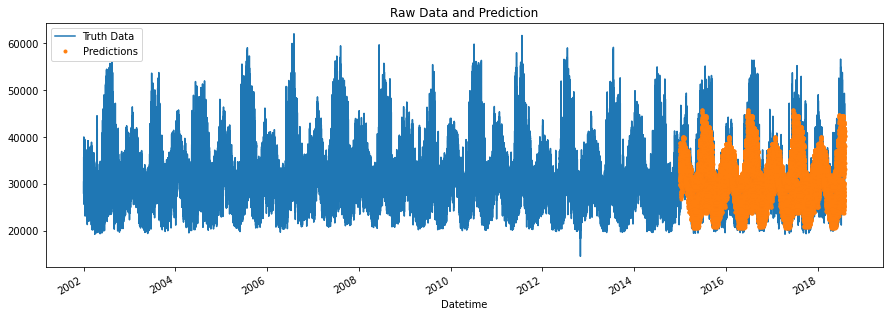

In [35]:
ax = data[['PJME_MW']].plot(figsize=(15, 5))
data['predictions'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')

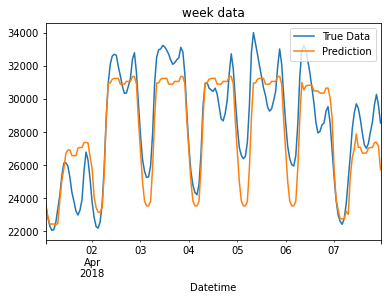

In [40]:
ax = data.loc[(data.index>'04-01-2018') & (data.index<'04-08-2018')]['PJME_MW'].plot(title='week data')
data.loc[(data.index>'04-01-2018') & (data.index<'04-08-2018')]['predictions'].plot()
plt.legend(['True Data','Prediction'])

In [41]:
from sklearn.metrics import confusion_matrix, classification_report

In [52]:
np.sqrt(mean_squared_error(test['PJME_MW'],test['predictions']))

3763.3525905941137

Worst predictions by model

In [55]:
test['error'] = np.abs(test[target]-test['predictions'])

In [56]:
test['error']

Datetime
2015-01-01 00:00:00     377.212891
2015-12-31 01:00:00    3272.238281
2015-12-31 02:00:00    4059.144531
2015-12-31 03:00:00    4256.021484
2015-12-31 04:00:00    4440.021484
                          ...     
2018-01-01 20:00:00    9287.070312
2018-01-01 21:00:00    8754.070312
2018-01-01 22:00:00    7752.773438
2018-01-01 23:00:00    7267.105469
2018-01-02 00:00:00    6183.212891
Name: error, Length: 31440, dtype: float64

In [59]:
test['date']=test.index.date

In [63]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head()

date
2016-08-13    14026.037760
2016-08-14    13533.325846
2016-09-10    13042.321940
2016-09-09    11385.571289
2015-02-20    10935.253174
Name: error, dtype: float64